In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from PIL import Image
import ast
import os
import cv2
from tqdm import tqdm

In [8]:
train_data = pd.read_csv("/kaggle/input/ranzcr-clip-catheter-line-classification/train.csv")
# CVC_train = train_data[["StudyInstanceUID","CVC - Abnormal", "CVC - Borderline", "CVC - Normal"]]
# CVC_train.set_index('StudyInstanceUID', inplace=True)
# CVC_train.head()

train_data[['CVC - Borderline', 'CVC - Normal', 'CVC - Abnormal']].value_counts()
train_data = train_data[train_data['CVC - Borderline'] != 1]
train_data['CVC - Present'] = np.where((train_data['CVC - Abnormal'] == 0) & (train_data['CVC - Normal'] == 0) & (train_data['CVC - Borderline'] == 0), 0, 1)

# train_data
# train_data['CVC - Borderline'] = np.where((train_data['CVC - Normal'] == 1) | (train_data['CVC - Abnormal'] == 1), 0, 0)


train_data['CVC - Present'].value_counts()

CVC - Present
1    20873
0      750
Name: count, dtype: int64

In [9]:
normalAb = pd.concat([train_data[train_data['CVC - Normal'] == 1].sample(n=375), train_data[train_data['CVC - Abnormal'] == 1].sample(n=375)])
sampled_data = pd.concat([normalAb, train_data[train_data['CVC - Present'] == 0].sample(n=750)])

sampled_data

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,CVC - Present
19114,1.2.826.0.1.3680043.8.498.15545280558359306592...,0,0,0,0,0,0,0,0,0,1,0,43991f139,1
23592,1.2.826.0.1.3680043.8.498.13241753899060669567...,0,0,0,0,0,0,0,0,0,1,0,248aeb1e5,1
15079,1.2.826.0.1.3680043.8.498.69568357530487565711...,0,0,1,0,0,1,0,0,0,1,0,d5f2964e8,1
16104,1.2.826.0.1.3680043.8.498.23083674843682950612...,0,0,0,0,0,0,0,0,0,1,0,374fdf7e6,1
3172,1.2.826.0.1.3680043.8.498.90920652004641735834...,0,0,0,0,0,0,0,0,0,1,0,a582ad1eb,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1.2.826.0.1.3680043.8.498.28924322411012007756...,0,1,0,0,0,0,1,0,0,0,0,f96cb8694,0
89,1.2.826.0.1.3680043.8.498.72960761368588005198...,0,0,1,0,0,0,1,0,0,0,0,9c3d0f8d0,0
5158,1.2.826.0.1.3680043.8.498.23145652854343081123...,0,0,1,0,0,0,0,0,0,0,0,767136533,0
21207,1.2.826.0.1.3680043.8.498.12270607627478409908...,0,0,1,0,0,0,1,0,0,0,0,fb5418dbf,0


In [10]:
def getFileNames(df):
    studyInstance = df['StudyInstanceUID'].tolist()
    studyInstance

    for i in range(len(studyInstance)):
        studyInstance[i] = f'{studyInstance[i]}.jpg'
      
    return studyInstance
    

In [11]:
studyInstance = getFileNames(sampled_data)

In [12]:
def processImages(filenames,train_test):

    imgs = []
    FileIDs = []
    lst = []


    desired_channels = 3

    count = 0
    for file in tqdm(filenames, position=0, leave=True):
        # Making sure the images are the same pixel size
        img = Image.open(f"/kaggle/input/ranzcr-clip-catheter-line-classification/{train_test}/{file}")
        img = img.resize((300, 300))
        img = np.array(img)

        # Ensure that the image has 3 channels (RGB)
        if img.shape[-1] != 3:
            img = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB by duplicating channels

        imgs.append(img)  # Append the 4D image to the list

        # Save filename for later
        FileIDs.append(file)

        count += 1

    # Convert the list of images to a numpy array
    imgs = np.array(imgs)
    return imgs, FileIDs

In [13]:
train_imgs, fileIDs = processImages(studyInstance, 'train')

100%|██████████| 1500/1500 [01:18<00:00, 18.99it/s]


In [14]:
#cleaning up the labels
UID = []
for i in range(len(fileIDs)):
  UID.append(fileIDs[i].replace(".jpg",""))

UID[0:10]

['1.2.826.0.1.3680043.8.498.15545280558359306592043139821967336271',
 '1.2.826.0.1.3680043.8.498.13241753899060669567805365396553626303',
 '1.2.826.0.1.3680043.8.498.69568357530487565711426727539093786421',
 '1.2.826.0.1.3680043.8.498.23083674843682950612654181074537766181',
 '1.2.826.0.1.3680043.8.498.90920652004641735834244128581550370412',
 '1.2.826.0.1.3680043.8.498.36263994952132673474878457413667505501',
 '1.2.826.0.1.3680043.8.498.13023658423431175942689489929098578329',
 '1.2.826.0.1.3680043.8.498.78851348262676480351066045263999245838',
 '1.2.826.0.1.3680043.8.498.53240259815683997837478699717200010071',
 '1.2.826.0.1.3680043.8.498.10652388808892795942501707012497293291']

In [15]:
columns_to_drop = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Normal',
                  "NGT - Incompletely Imaged", "Swan Ganz Catheter Present", "PatientID", "CVC - Borderline", 'CVC - Abnormal', 'CVC - Normal']

CVCsampled_data = sampled_data.drop(columns=columns_to_drop, axis=1)

CVCsampled_data.set_index('StudyInstanceUID', inplace=True)

CVCsampled_data

,CVC - Present
StudyInstanceUID,
1.2.826.0.1.3680043.8.498.15545280558359306592043139821967336271,1
1.2.826.0.1.3680043.8.498.13241753899060669567805365396553626303,1
1.2.826.0.1.3680043.8.498.69568357530487565711426727539093786421,1
1.2.826.0.1.3680043.8.498.23083674843682950612654181074537766181,1
1.2.826.0.1.3680043.8.498.90920652004641735834244128581550370412,1
...,...
1.2.826.0.1.3680043.8.498.28924322411012007756657474550402323157,0
1.2.826.0.1.3680043.8.498.72960761368588005198860590269949555163,0
1.2.826.0.1.3680043.8.498.23145652854343081123332419871776236291,0


In [16]:
# train_labels_df = np.empty((0,3))
# data = []

# for ID in UID:
#     data.append(CVCsampled_data.loc[ID])

# train_labels_df = pd.DataFrame(data)
# train_labels_df = train_labels_df.reindex(UID)

# train_labels = train_labels_df['CVC - Present'].values
# # train_labels = train_labels_df.values
# train_labels
train_labels = CVCsampled_data['CVC - Present'].values
train_labels

array([1, 1, 1, ..., 0, 0, 0])

In [17]:
from sklearn.model_selection import train_test_split

# Split your data into training and temporary data (combined validation and test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=42)

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# CVC Detection

# NORMAL OR ABNORMAL

In [19]:
def buildTrainData(catheter, train_data, size):
    
    train_data = train_data[train_data[f'{catheter} - Present'] == 1]
    train_data = train_data = train_data[~((train_data[f'{catheter} - Normal'] == 1) & (train_data[f'{catheter} - Abnormal'] == 1))]
    train_data[f'{catheter} - Normal/Abnormal'] = np.where(train_data[f'{catheter} - Normal'] == 1, 1, 0)
    sampled_data = pd.concat([train_data[train_data[f'{catheter} - Normal'] == 1].sample(n=size), train_data[train_data[f'{catheter} - Abnormal'] == 1].sample(n=size)])
    
    return sampled_data
    

In [20]:
sample = buildTrainData('CVC', train_data, 750)
sample

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,CVC - Present,CVC - Normal/Abnormal
24374,1.2.826.0.1.3680043.8.498.10753158460521964229...,0,0,0,0,0,0,0,0,0,1,0,c6ce055cc,1,1
21919,1.2.826.0.1.3680043.8.498.20650080923791326177...,0,0,0,0,0,0,0,0,0,1,0,20c6fd8b6,1,1
6733,1.2.826.0.1.3680043.8.498.67697742086859288675...,0,0,0,0,0,0,0,0,0,1,0,e9079712c,1,1
29948,1.2.826.0.1.3680043.8.498.46995347507398457131...,0,0,0,0,0,0,0,0,0,1,0,a7101a712,1,1
16655,1.2.826.0.1.3680043.8.498.53447606314578131317...,0,0,0,0,0,0,0,0,0,1,0,871190b8e,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28408,1.2.826.0.1.3680043.8.498.10086330306179289357...,0,0,0,0,0,0,0,1,0,0,0,588da75f3,1,0
16360,1.2.826.0.1.3680043.8.498.72960294903069762440...,0,0,0,0,0,0,0,1,0,0,0,552747e2c,1,0
28823,1.2.826.0.1.3680043.8.498.67415897614395172379...,0,1,0,0,0,0,1,1,0,0,0,da2d72698,1,0
18105,1.2.826.0.1.3680043.8.498.68847325485770133626...,0,0,0,0,0,0,0,1,0,0,0,1f9875e8c,1,0


In [21]:
nAb_data = getFileNames(sample)

cvc_imgs, fileIDs = processImages(nAb_data, 'train')

100%|██████████| 1500/1500 [01:19<00:00, 18.89it/s]


In [22]:
UID = []
for i in range(len(fileIDs)):
  UID.append(fileIDs[i].replace(".jpg",""))


columns_to_drop = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Normal',
                  "NGT - Incompletely Imaged", "Swan Ganz Catheter Present", "PatientID", "CVC - Borderline", 'CVC - Abnormal', 'CVC - Normal', 'CVC - Present']

CVCsample = sample.drop(columns=columns_to_drop, axis=1)

CVCsample.set_index('StudyInstanceUID', inplace=True)

CVCsample

,CVC - Normal/Abnormal
StudyInstanceUID,
1.2.826.0.1.3680043.8.498.10753158460521964229669140561429660970,1
1.2.826.0.1.3680043.8.498.20650080923791326177288158982315944799,1
1.2.826.0.1.3680043.8.498.67697742086859288675505303808787533405,1
1.2.826.0.1.3680043.8.498.46995347507398457131600938711896238959,1
1.2.826.0.1.3680043.8.498.53447606314578131317001502359237392243,1
...,...
1.2.826.0.1.3680043.8.498.10086330306179289357102351647610229849,0
1.2.826.0.1.3680043.8.498.72960294903069762440427746865505834653,0
1.2.826.0.1.3680043.8.498.67415897614395172379029818296174445119,0


In [23]:
train_labels_df = np.empty((0,3))
data = []

for ID in UID:
    data.append(CVCsample.loc[ID])

train_labels_df = pd.DataFrame(data)



train_labels_df = train_labels_df.reindex(UID)
cvc_labels = train_labels_df['CVC - Normal/Abnormal'].values
# train_labels = train_labels_df.values
cvc_labels

array([1, 1, 1, ..., 0, 0, 0])

In [24]:
from sklearn.model_selection import train_test_split

# Split your data into training and temporary data (combined validation and test)
trainCVC_imgs, temp_imgs, trainCVC_labels, temp_labels = train_test_split(cvc_imgs, cvc_labels, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets
valCVC_imgs, testCVC_imgs, valCVC_labels, testCVC_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=42)

In [25]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model


from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False)

# Add dropout and batch normalization to custom fully connected layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# First Output Branch: CVC Catheter Presence (Binary Classification)
output_CVCpresent = Dense(1, activation='sigmoid', name='output_CVCpresent')(x)

# Add a separate set of layers for the new task
y = base_model.output
y = GlobalAveragePooling2D()(y)
y = Dense(1024, activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)

# Second Output Branch: CVC Placement (Binary Classification)
output_cvc_placement = Dense(1, activation='sigmoid', name='output_CVCnormalAbnormal')(y)

# Combine the two output branches
combined_model = Model(inputs=base_model.input, outputs=[output_CVCpresent, output_cvc_placement])

# Compile the combined model with optimizer and loss functions for both tasks
combined_model.compile(optimizer='SGD', 
                       loss={'output_CVCpresent': 'binary_crossentropy', 'output_CVCnormalAbnormal': 'binary_crossentropy'}, 
                       metrics={'output_CVCpresent': 'accuracy', 'output_CVCnormalAbnormal': 'accuracy'})

# # Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the best model during training
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

history = combined_model.fit(
    {'input_1': train_imgs},
    {'output_CVCpresent': train_labels, 'output_CVCnormalAbnormal': trainCVC_labels},
    epochs=30,
    validation_data=(
        {'input_1': val_imgs},
        {'output_CVCpresent': val_labels, 'output_CVCnormalAbnormal': valCVC_labels}
    ),
    callbacks=[reduce_lr, early_stop, model_checkpoint]
)


94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/30
38/38 [==============================] - 42s 436ms/step - loss: 1.5650 - output_CVCpresent_loss: 0.7840 - output_CVCnormalAbnormal_loss: 0.7810 - output_CVCpresent_accuracy: 0.6325 - output_CVCnormalAbnormal_accuracy: 0.6467 - val_loss: 1.3351 - val_output_CVCpresent_loss: 0.6200 - val_output_CVCnormalAbnormal_loss: 0.7151 - val_output_CVCpresent_accuracy: 0.6867 - val_output_CVCnormalAbnormal_accuracy: 0.6067 - lr: 0.0100
Epoch 2/30
38/38 [==============================] - 11s 299ms/step - loss: 1.0318 - output_CVCpresent_loss: 0.5143 - output_CVCnormalAbnormal_loss: 0.5176 - output_CVCpresent_accuracy: 0.7650 - output_CVCnormalAbnormal_accuracy: 0.7733 - val_loss: 2.0355 - val_output_CVCpresent_loss: 1.3539 - val_output_CVCnormalAbnormal_loss: 0.6816 - val_output_CVCpresent_accuracy: 0.4333 - val_output_CVCnormalAbnormal_accuracy: 0.5733 - lr: 0.0100
Epoch 3/30
38/38 [==============================] - 11s 299

In [26]:
# Evaluate accuracy for the 'output_catheter' branch
evaluation = combined_model.evaluate(
    {'input_1': test_imgs},
    {'output_CVCpresent': test_labels, 'output_CVCnormalAbnormal': testCVC_labels},
)

# Extract the accuracy values from the evaluation results
test_accuracy_catheter = evaluation[3]  # Index 3 corresponds to 'output_catheter_accuracy'
test_accuracy_cvc_placement = evaluation[4]  # Index 4 corresponds to 'output_cvc_placement_accuracy'

print(f'Test Accuracy (CVC Present): {test_accuracy_catheter * 100:.2f}%')
print(f'Test Accuracy (CVC Normal/Abnormal): {test_accuracy_cvc_placement * 100:.2f}%')


5/5 [==============================] - 0s 83ms/step - loss: 1.3175 - output_CVCpresent_loss: 0.6409 - output_CVCnormalAbnormal_loss: 0.6766 - output_CVCpresent_accuracy: 0.7267 - output_CVCnormalAbnormal_accuracy: 0.7200
Test Accuracy (CVC Present): 72.67%
Test Accuracy (CVC Normal/Abnormal): 72.00%


5/5 [==============================] - 1s 85ms/step


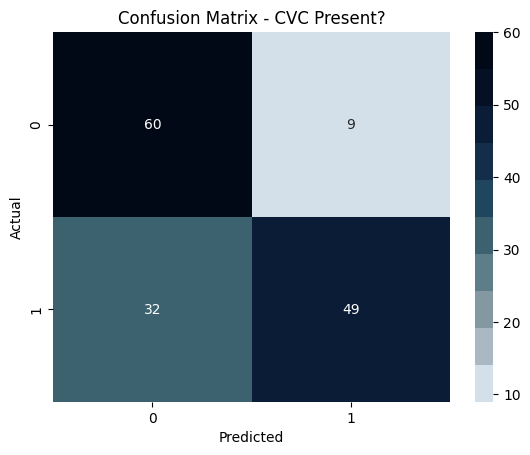

<Figure size 640x480 with 0 Axes>

In [27]:
# Make predictions
predictions = combined_model.predict(test_imgs)
predictions

# Access predictions for the first task
cvc_present_predictions = predictions[0]
cvc_present_predictions
# Access predictions for the second task
cvc_normal_abnormal_predictions = predictions[1]

cvc_present_predictions
# Create two separate DataFrames
df1 = pd.DataFrame(cvc_present_predictions, columns=["CVC - Present"])
df2 = pd.DataFrame(cvc_normal_abnormal_predictions, columns=['CVC - Normal/Abnormal'])

# # Concatenate the DataFrames horizontally to create one with two columns
CVCpredictions = pd.concat([df1, df2], axis=1)
CVCpredictions

CVCpredictions['CVC - Present'] = np.where(CVCpredictions['CVC - Present'] > 0.5, 1, 0)
CVCpredictions['CVC - Normal/Abnormal'] = np.where(CVCpredictions['CVC - Normal/Abnormal'] > 0.5, 1, 0)
CVCpredictions

from sklearn.metrics import confusion_matrix

# Create the confusion matrix
confusion_matrix_present = confusion_matrix(test_labels, CVCpredictions['CVC - Present'])

plt.gca().patch.set_facecolor('none')



custom_palette = ['#D3E0EA', '#AAB8C4', '#8498A2', '#5D7D88', '#3C6270', 
                  '#1F465E', '#132D4B', '#0A1C36', '#051024', '#020916']

# Create a heatmap plot of the confusion matrix
sns.heatmap(confusion_matrix_present, annot=True, cmap=custom_palette)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CVC Present?')
plt.show()


plt.savefig('confusionmatrix_CVCexistence.png', bbox_inches='tight', transparent=True)


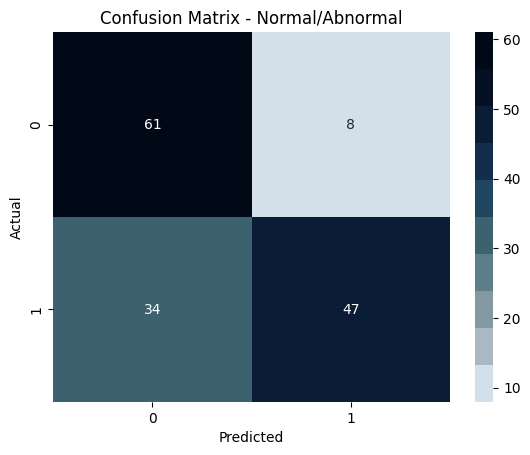

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix_normal = confusion_matrix(testCVC_labels, CVCpredictions['CVC - Normal/Abnormal'])

plt.gca().patch.set_facecolor('none')



custom_palette = ['#D3E0EA', '#AAB8C4', '#8498A2', '#5D7D88', '#3C6270', 
                  '#1F465E', '#132D4B', '#0A1C36', '#051024', '#020916']

# Create a heatmap plot of the confusion matrix
sns.heatmap(confusion_matrix_normal, annot=True, cmap=custom_palette)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Normal/Abnormal')
plt.show()


# plt.savefig('confusionmatrix_CVCexistence.png', bbox_inches='tight', transparent=True)

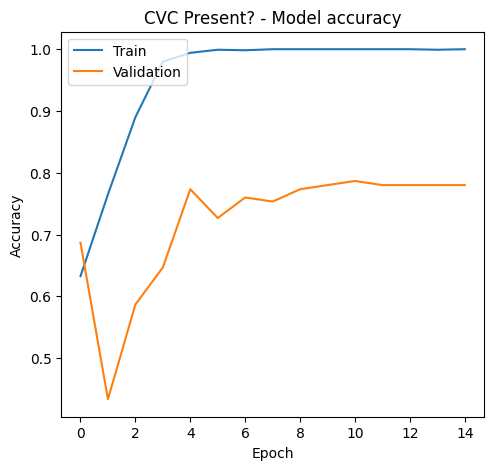

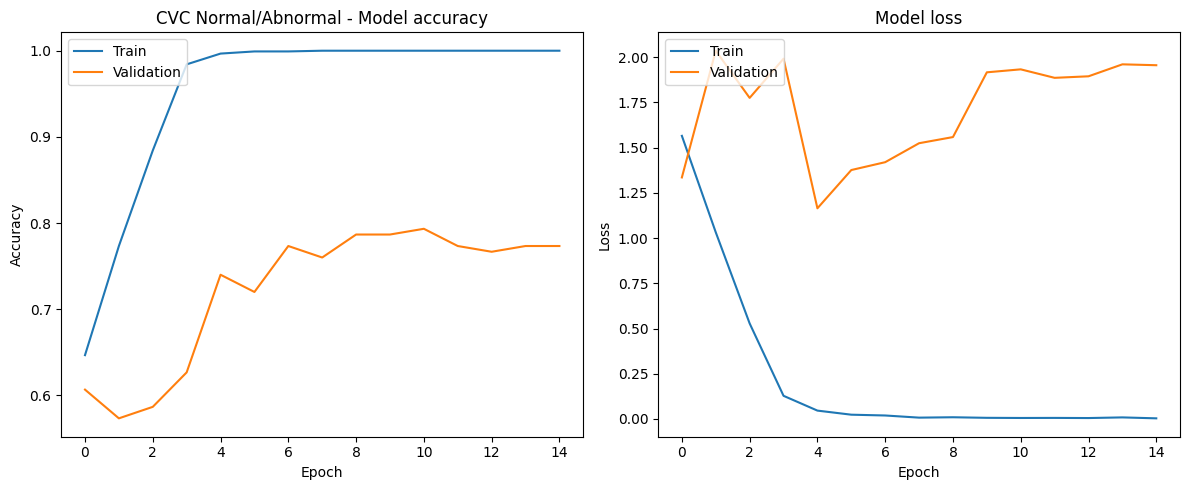

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['output_CVCpresent_accuracy'])
plt.plot(history.history['val_output_CVCpresent_accuracy'])
plt.title('CVC Present? - Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['output_CVCnormalAbnormal_accuracy'])
plt.plot(history.history['val_output_CVCnormalAbnormal_accuracy'])
plt.title('CVC Normal/Abnormal - Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()